# Pipeline for High-z Radio Galaxies 03: Radio detection classification with confirmed AGN

## Introduction

Training for classification of sources with and without radio detection in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and those predicted  
to be AGN by the initial Galaxy/AGN classification model (`ML_01.ipynb`).  

Being either AGN or galaxy will be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.metrics import matthews_corrcoef, precision_recall_curve, PrecisionRecallDisplay, auc
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
from joblib import dump, load
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

***

## Reading data

We import our data using the `pandas` package.

In [3]:
save_plot_flag         = False
save_model_flag        = False
use_AGN_gal_model_flag = False
load_model_flag        = True

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [4]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'Z', 'zsp', 'X_ray_detect', 'Total_flux_VLASS', 'Sint_LOFAR',\
                      'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag', 'spCl',\
                      'FUVmag', 'NUVmag', 'num_imputed'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [5]:
full_catalog_df = pd.read_hdf(gv.cat_path + gv.file_HETDEX, key='df').drop(columns=features_2_discard)

In [6]:
# full_catalog_df.describe()

#### Load previous model to create labels for unknown sources (in general, do not use this).

In [7]:
confirmed_indices = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)].index
unknown_indices   = full_catalog_df.drop(index=confirmed_indices).index
final_indices     = confirmed_indices.union(unknown_indices)  # all

In [8]:
print(f'There are {np.sum(full_catalog_df.loc[:, "is_AGN"] == 1):,} confirmed AGN in this dataset.')

There are 28,251 confirmed AGN in this dataset.


In [9]:
if use_AGN_gal_model_flag:
    AGN_gal_clf = pyc.load_model(gv.models_path + gv.AGN_gal_model)  # From ML_16.ipynb

In [10]:
if use_AGN_gal_model_flag:
    new_labels_train   = pyc.predict_model(AGN_gal_clf, data=full_catalog_df,\
                                           probability_threshold=gv.AGN_thresh,\
                                           raw_score=True).loc[:, 'Score_1']

In [11]:
if use_AGN_gal_model_flag:
    full_catalog_df['class'] = new_labels_train.copy()

In [12]:
if use_AGN_gal_model_flag:
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(full_catalog_df.loc[:, 'is_gal'] == 1, 0)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(full_catalog_df.loc[:, 'is_AGN'] == 1, 1)

#### Select only confirmed and highly likely AGN

In [13]:
if use_AGN_gal_model_flag:
    AGN_threshold = 0.95
    gal_threshold = 0.05

In [14]:
if use_AGN_gal_model_flag:
    filter_upgrade_AGN = (full_catalog_df.loc[:, 'class'] > AGN_threshold) & (full_catalog_df.loc[:, 'class'] < 1.00)
    filter_upgrade_gal = (full_catalog_df.loc[:, 'class'] < gal_threshold) & (full_catalog_df.loc[:, 'class'] > 0.00)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_AGN, 1)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_gal, 0)

In [15]:
if not use_AGN_gal_model_flag:
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

In [16]:
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].astype(int)

In [17]:
target_feat = 'radio_detect'

## Possible correlations

In [18]:
print(full_catalog_df.columns.to_list())

['band_num', 'radio_detect', 'is_str', 'is_SDSS_QSO', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4', 'class']


---

Create target

In [19]:
full_catalog_df.loc[:, target_feat] = full_catalog_df.loc[:, target_feat].astype(int)

## Split data: Test, Train, Validation

Create same train/test/validation sub-sets as with AGN/galaxy model.  
After this, select sources needed for this model (`class == 1`)

In [20]:
filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df   = full_catalog_df.loc[filter_known_spec]
train_test_df, validation_df     = train_test_split(full_catalog_df, test_size=0.2,\
                                    random_state=gv.seed, stratify=full_catalog_df.loc[:, 'class'])
train_df, test_df                = train_test_split(train_test_df, test_size=0.3,\
                                    random_state=gv.seed, stratify=train_test_df.loc[:, 'class'])
print('Shape of used data in HETDEX')
print('(Confirmed galaxies and AGN)')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'validation data:                    {validation_df.shape}')
print('-' * 50)
print()

Shape of used data in HETDEX
(Confirmed galaxies and AGN)
--------------------------------------------------
Full confirmed dataset size:        (83409, 86)
Data for Modeling (Train and Test): (66727, 86)
Training data:                      (46708, 86)
Testing data:                       (20019, 86)
validation data:                    (16682, 86)
--------------------------------------------------



In [21]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'class'] == 1)]
train_test_df   = train_test_df.loc[(train_test_df.loc[:, 'class'] == 1)]
train_df        = train_df.loc[(train_df.loc[:, 'class'] == 1)]
test_df         = test_df.loc[(test_df.loc[:, 'class'] == 1)]
validation_df   = validation_df.loc[(validation_df.loc[:, 'class'] == 1)]

In [22]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'class'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, target_feat] == 1)
print(f'In this dataset (HETDEX), with {len(full_catalog_df.loc[:, "is_AGN"]):,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, and, from them, {n_is_rad:,} have confirmed radio detection.')

In this dataset (HETDEX), with 28,251 elements,
28,251 of them are marked as AGN, and, from them, 8,518 have confirmed radio detection.


Remove intermediate targets

In [23]:
cols_to_discard_classes = ['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'class', 'is_str']
full_catalog_df = full_catalog_df.drop(columns=cols_to_discard_classes)
train_test_df   = train_test_df.drop(columns=cols_to_discard_classes)
train_df        = train_df.drop(columns=cols_to_discard_classes)
test_df         = test_df.drop(columns=cols_to_discard_classes)
validation_df   = validation_df.drop(columns=cols_to_discard_classes)

---

In [24]:
print('Final shape of used data')
print('-' * 50)
print('(Confirmed AGN)')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'Validation data:                    {validation_df.shape}')
print('-' * 50)

Final shape of used data
--------------------------------------------------
(Confirmed AGN)
--------------------------------------------------
Full confirmed dataset size:        (28251, 80)
Data for Modeling (Train and Test): (22601, 80)
Training data:                      (15820, 80)
Testing data:                       (6781, 80)
Validation data:                    (5650, 80)
--------------------------------------------------


---

## Use Correlation matrix to discard some features

In [25]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [26]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [27]:
rsd_vals

K_W3            624.424131
z_y             516.256644
i_z             326.853578
i_y             237.564569
r_i             173.388802
radio_detect    151.546369
r_y             144.427476
g_r             144.193405
r_z             143.625234
g_i             112.576827
g_y             107.516920
g_z             104.764871
W1_W2            91.869769
y_W1             67.729441
z_W1             59.368716
H_W3             58.563533
i_W1             53.996987
r_W1             52.870262
g_W1             52.824714
y_W2             52.603153
z_W2             45.878199
J_W3             45.081374
i_W2             41.339035
y_J              40.973477
g_W2             40.358603
r_W2             40.235013
y_H              37.844857
z_J              37.588309
i_J              35.690666
z_H              34.812818
W2_W3            34.482810
r_J              34.098272
i_H              33.172435
y_K              32.440916
W1_W3            32.249316
g_J              32.095223
r_H              31.849533
g

In [28]:
correlation    = norm_train_test_df.corr()

In [29]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [30]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [31]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [32]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [33]:
list_drop_corr

['y_H',
 'g_H',
 'r_H',
 'z_H',
 'i_H',
 'J_W1',
 'J_W2',
 'y_K',
 'J_W3',
 'z_K',
 'i_K',
 'r_K',
 'g_K',
 'H_W1',
 'H_W2',
 'Jmag',
 'J_W4',
 'K_W1',
 'K_W2',
 'ymag',
 'zmag',
 'W1mproPM',
 'imag',
 'rmag',
 'gmag',
 'W2mproPM',
 'y_W4',
 'g_W4',
 'r_W4',
 'z_W4',
 'i_W4',
 'W1_W4',
 'Kmag',
 'W2_W4',
 'H_W3',
 'r_J',
 'g_W2',
 'J_K',
 'W1_W3',
 'r_W3',
 'i_J',
 'y_W3',
 'r_W2',
 'i_W3',
 'g_W3',
 'z_W3',
 'y_W2',
 'z_W2',
 'i_W2',
 'g_W1',
 'r_W1',
 'H_W4',
 'W3mag',
 'z_J',
 'Hmag',
 'i_W1',
 'g_y',
 'W3_W4',
 'r_y',
 'g_z',
 'g_J',
 'g_i']

In [34]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [35]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [36]:
corr_discard = norm_train_test_discard.corr()

In [37]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

band_num  band_num    1.000000
z_y       i_y         0.737201
y_J       W2_W3       0.736708
band_num  y_J         0.728645
z_W1      y_W1        0.719265
W4mag     K_W3        0.688022
i_z       r_z         0.671493
K_W3      K_W4        0.636035
W2_W3     band_num    0.610033
r_i       r_z         0.571296
W4mag     K_W4        0.568049
K_W3      y_J         0.517616
band_num  H_K         0.485582
y_J       y_W1        0.467664
W1_W2     H_K         0.454817
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

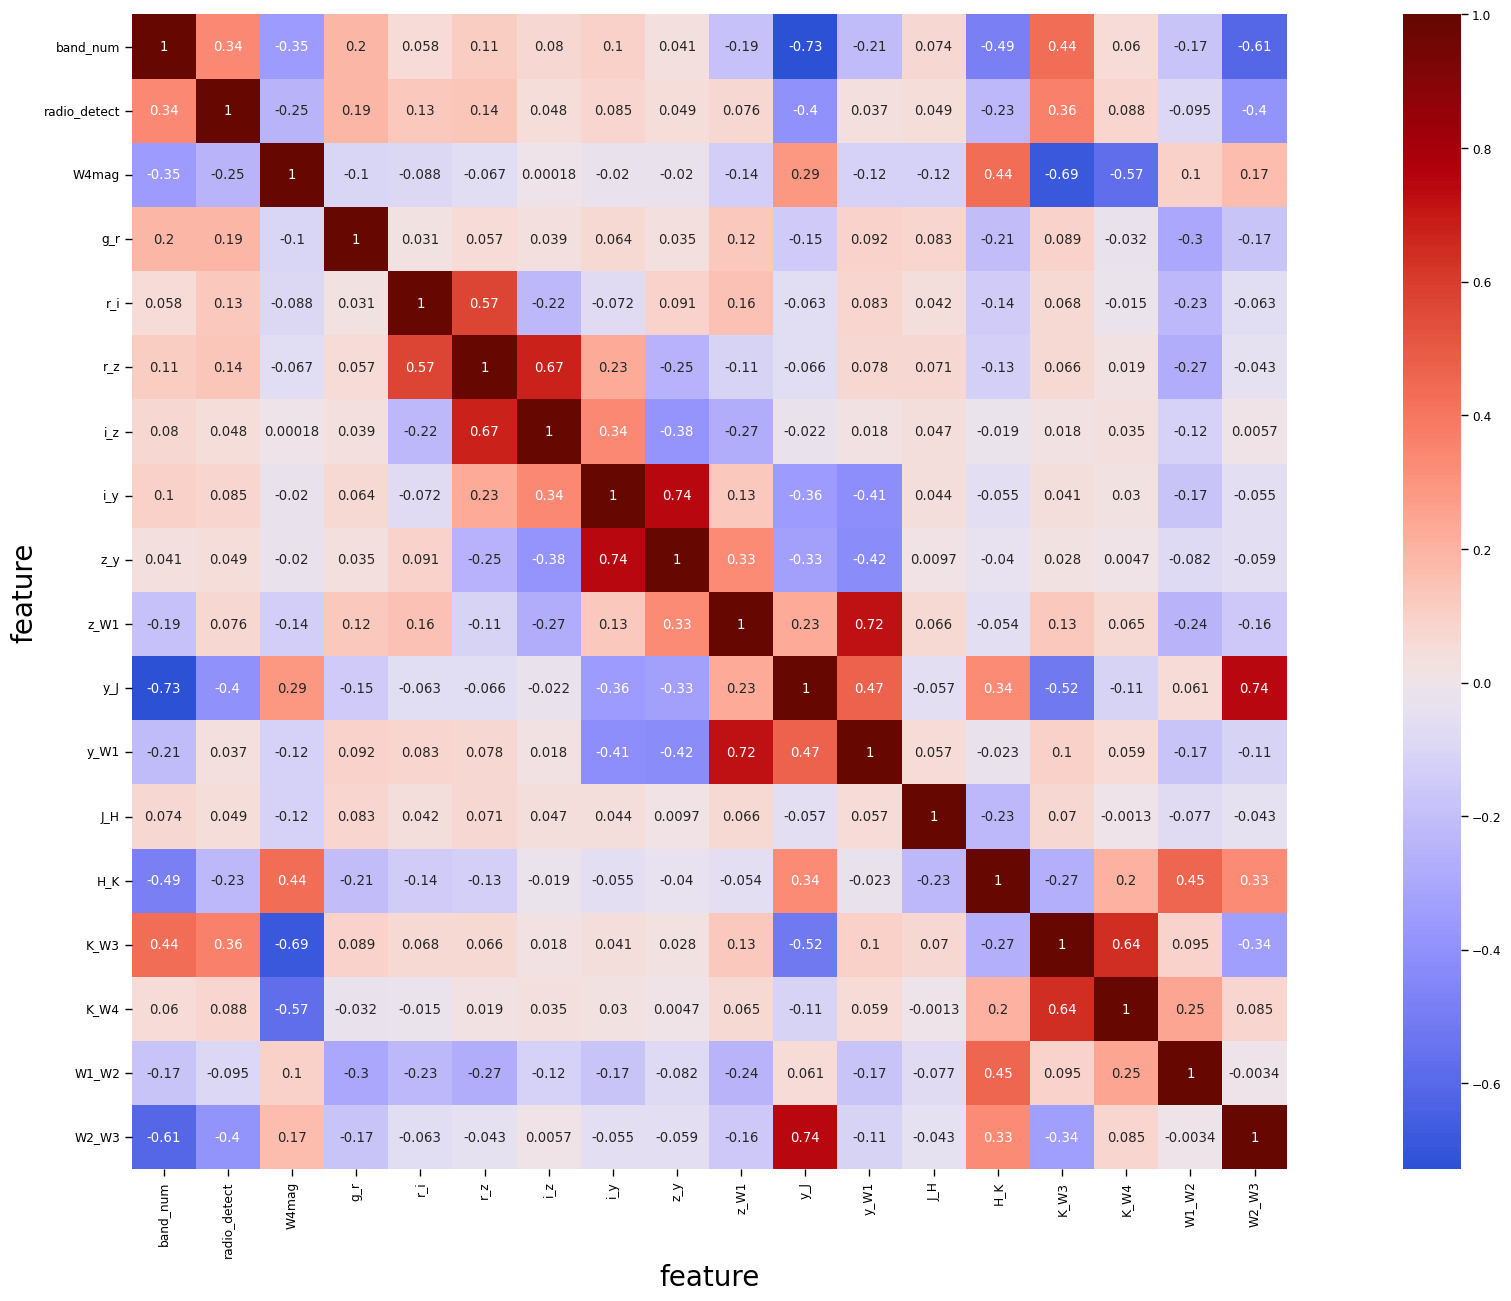

In [38]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [39]:
norm_train_test_discard.loc[:, target_feat] = norm_train_test_discard.loc[:, target_feat].astype(bool)

In [40]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=gv.seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [41]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y           
H_K       H_K             1.000000
band_num  y_J             0.583463
K_W4      W4mag           0.479233
J_H       H_K             0.377591
band_num  z_y             0.326286
K_W3      radio_detect    0.321808
band_num  W2_W3           0.295017
z_y       i_y             0.278370
y_J       band_num        0.263354
z_y       y_J             0.243914
band_num  radio_detect    0.229282
y_J       radio_detect    0.228483
K_W4      radio_detect    0.227825
K_W3      W4mag           0.226845
y_W1      z_W1            0.220211
band_num  i_y             0.220024
W2_W3     y_J             0.214692
          radio_detect    0.213441
K_W3      W2_W3           0.211814
y_J       W2_W3           0.209362
dtype: float64

In [42]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [43]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [44]:
list_drop_pps = []

In [45]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [46]:
list_drop_pps

[]

In [47]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [48]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'radio_detect', random_seed=gv.seed)

In [49]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,K_W3,radio_detect,0.321808,classification,True,weighted F1,0.5908,0.722484,DecisionTreeClassifier()
1,band_num,radio_detect,0.229282,classification,True,weighted F1,0.5908,0.684622,DecisionTreeClassifier()
2,y_J,radio_detect,0.228483,classification,True,weighted F1,0.5908,0.684295,DecisionTreeClassifier()
3,K_W4,radio_detect,0.227825,classification,True,weighted F1,0.5908,0.684026,DecisionTreeClassifier()
4,W2_W3,radio_detect,0.213441,classification,True,weighted F1,0.5908,0.678140,DecisionTreeClassifier()
5,W4mag,radio_detect,0.202543,classification,True,weighted F1,0.5908,0.673681,DecisionTreeClassifier()
6,J_H,radio_detect,0.154699,classification,True,weighted F1,0.5908,0.654103,DecisionTreeClassifier()
7,H_K,radio_detect,0.146720,classification,True,weighted F1,0.5908,0.650838,DecisionTreeClassifier()
8,W1_W2,radio_detect,0.134055,classification,True,weighted F1,0.5908,0.645655,DecisionTreeClassifier()
9,r_i,radio_detect,0.080754,classification,True,weighted F1,0.5908,0.623844,DecisionTreeClassifier()


In [50]:
print(f'{len(full_catalog_df):,}')

28,251


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [51]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta

In [52]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards no features.

In [53]:
exp_radio = pyc.setup(data=train_df, test_data=test_df, target=target_feat, session_id=gv.seed, silent=True,\
                      feature_selection=False, feature_selection_method='boruta', data_split_stratify=True,\
                      numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                      transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                      normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,radio_detect
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(15820, 80)"
5,Missing Values,False
6,Numeric Features,17
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [54]:
pyc.get_config('X').columns

Index(['band_num', 'W4mag', 'g_r', 'r_i', 'r_z', 'i_z', 'i_y', 'z_y', 'z_W1',
       'y_J', 'y_W1', 'J_H', 'H_K', 'K_W3', 'K_W4', 'W1_W2', 'W2_W3'],
      dtype='object')

In [55]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [56]:
metric_2_sort         = 'Recall'
final_selection_clf   = ['rf', 'catboost', 'xgboost', 'et', 'gbc', 'dummy']  # lightgbm is selected to be base learner.
initial_selection_clf = ['rf', 'gbc', 'et', 'xgboost', 'catboost', 'dummy']  # Only tree-based models (except lightgbm,dt)
n_models              = 5
top_model_radio = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort=metric_2_sort)  # 1:15 hour for used_models_clf
# top_model_radio = pyc.compare_models(n_select=n_models, include=initial_selection_clf, sort=metric_2_sort)  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7777,0.7986,0.4873,0.6917,0.5713,0.4274,0.4397,0.4680
catboost,CatBoost Classifier,0.7796,0.8076,0.4838,0.6995,0.5715,0.4298,0.4433,1.1320
xgboost,Extreme Gradient Boosting,0.7674,0.7881,0.4767,0.6644,0.5548,0.4031,0.4135,8.6780
et,Extra Trees Classifier,0.7733,0.7950,0.4678,0.6879,0.5564,0.4115,0.4256,0.1290
gbc,Gradient Boosting Classifier,0.7786,0.8051,0.4622,0.7095,0.5593,0.4203,0.4377,0.5700
dummy,Dummy Classifier,0.6957,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0150


Thus, we will select `catboost` as meta learner without it having the best Recall.

Thus, we stack the models.

In [57]:
# stacked_model_radio = pyc.stack_models(estimator_list=top_model_radio[1:], meta_model=top_model_radio[0], optimize=metric_2_sort, restack=True)
stacked_model_radio = pyc.stack_models(estimator_list=top_model_radio[0:1] + top_model_radio[2:],\
                                       meta_model=top_model_radio[1], optimize=metric_2_sort, restack=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7604,0.7923,0.4449,0.6564,0.5304,0.3774,0.3903
1,0.7914,0.8093,0.4886,0.7367,0.5875,0.4555,0.4727
2,0.7863,0.7944,0.5156,0.7025,0.5947,0.4543,0.4643
3,0.7958,0.8277,0.5052,0.7409,0.6007,0.4701,0.4856
4,0.7851,0.8170,0.5177,0.6975,0.5943,0.4524,0.4617
5,0.7788,0.8158,0.4802,0.6979,0.5690,0.4269,0.4404
6,0.7554,0.7953,0.4170,0.6547,0.5095,0.3571,0.3732
7,0.7813,0.8135,0.5373,0.6780,0.5995,0.4519,0.4576
8,0.7737,0.7876,0.5000,0.6732,0.5738,0.4243,0.4330


In [58]:
tuned_radio_clf = pyc.tune_model(stacked_model_radio, early_stopping=True, optimize=metric_2_sort,\
                                 search_library='tune-sklearn', search_algorithm='bayesian', choose_better=True)  # 1h30

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7630,0.7281,0.5738,0.6188,0.5955,0.4282,0.4288
1,0.7788,0.7624,0.5821,0.6527,0.6154,0.4608,0.4623
2,0.7838,0.7596,0.5593,0.6742,0.6114,0.4634,0.4673
3,0.7889,0.7645,0.6050,0.6690,0.6354,0.4873,0.4885
4,0.7813,0.7635,0.6029,0.6517,0.6263,0.4721,0.4728
5,0.7743,0.7614,0.6445,0.6250,0.6346,0.4714,0.4715
6,0.7509,0.7306,0.4896,0.6146,0.5450,0.3766,0.3812
7,0.7579,0.7622,0.6722,0.5902,0.6285,0.4501,0.4522
8,0.7560,0.7394,0.5685,0.6062,0.5867,0.4139,0.4143


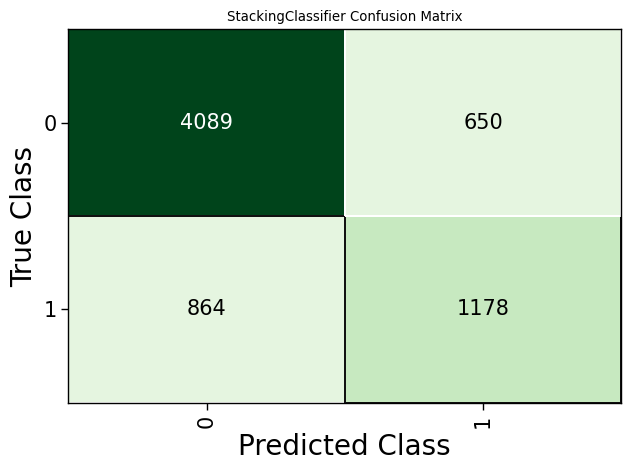

In [59]:
pyc.plot_model(tuned_radio_clf, plot='confusion_matrix')

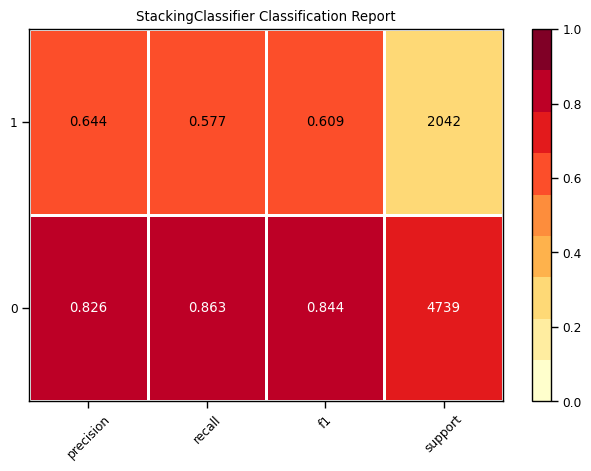

In [60]:
pyc.plot_model(tuned_radio_clf, plot='class_report')

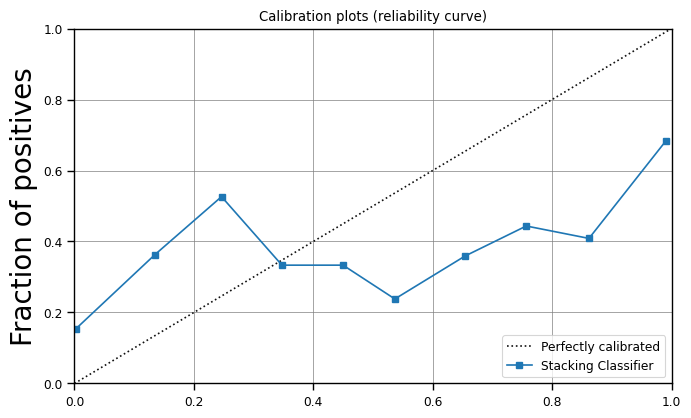

In [61]:
pyc.plot_model(tuned_radio_clf, plot='calibration')

In [79]:
# pyc.plot_model(tuned_radio_clf.estimators_[0], plot='feature_all')

In [62]:
pyc.plot_model(tuned_radio_clf.final_estimator_, plot='parameter')

,Parameters
nan_mode,Min
eval_metric,Logloss
iterations,77
sampling_frequency,PerTree
leaf_estimation_method,Newton
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Plain
model_shrink_mode,Constant
feature_border_type,GreedyLogSum


In [63]:
plt.rcParams.update(plt.rcParamsDefault)

In [64]:
pyc.predict_model(tuned_radio_clf, probability_threshold=gv.naive_radio_thresh, raw_score=True).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7767,0.7636,0.5769,0.6444,0.6088,0.4532,0.4546


,Score_0,Score_1
count,6781.000000,6781.000000
mean,0.502926,0.497074
std,0.002724,0.002724
min,0.498500,0.495200
25%,0.499400,0.495200
50%,0.504800,0.495200
75%,0.504800,0.500600
max,0.504800,0.501500


In [65]:
test_prediction_clf = pyc.predict_model(tuned_radio_clf, probability_threshold=gv.naive_radio_thresh, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7767,0.7636,0.5769,0.6444,0.6088,0.4532,0.4546


In [ ]:
final_radio_clf = pyc.finalize_model(tuned_radio_clf)

In [67]:
pyc.predict_model(final_radio_clf, probability_threshold=gv.naive_radio_thresh, raw_score=True).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7767,0.7636,0.5769,0.6444,0.6088,0.4532,0.4546


,Score_0,Score_1
count,6781.000000,6781.000000
mean,0.502926,0.497074
std,0.002724,0.002724
min,0.498500,0.495200
25%,0.499400,0.495200
50%,0.504800,0.495200
75%,0.504800,0.500600
max,0.504800,0.501500


In [68]:
if save_model_flag:
    # pyc.save_model(final_radio_clf, 'models/classification_radio_detect_may_16_2022')  # Model (it will be saved with .pkl extension)
    pyc.save_model(final_radio_clf, gv.models_path + gv.radio_model)  # Model (it will be saved with .pkl extension)

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [54]:
if load_model_flag:
    final_radio_clf = pyc.load_model(gv.models_path + gv.radio_model)

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [55]:
base_models_names = gf.get_base_estimators_names(final_radio_clf)
base_models       = gf.get_base_estimators_models(final_radio_clf)

In [56]:
print('Running data pre-processing:\n')
extended_data_radio_df = gf.preprocess_data(final_radio_clf, validation_df, base_models_names)

Running data pre-processing:



In [57]:
coef_sorted_meta_df = gf.feat_importances_meta_model(final_radio_clf, extended_data_radio_df)

In [58]:
coef_sorted_base_df = gf.feat_importances_base_models(base_models_names, base_models, extended_data_radio_df)

In [59]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [60]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for rf...
Calculating for xgboost...
Calculating for et...
Calculating for gbc...


rf              xgboost                   et                  gbc  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0      W2_W3  12.390435      K_W3  31.176790     W2_W3  12.353068      K_W3   
1        y_J   9.476183     W4mag  14.755308       y_J   8.237863     W2_W3   
2       K_W3   8.924298     W2_W3   8.717365       g_r   7.661811       y_J   
3        g_r   8.475018       y_J   5.625892       r_z   7.243575       g_r   
4        r_z   7.351783       g_r   4.127072     W1_W2   6.985542       r_z   
5      W1_W2   7.155305       r_z   3.901536       r_i   6.900353     W4mag   
6        r_i   7.019577     W1_W2   3.623841      z_W1   6.679036     W1_W2   
7       z_W1   6.591085      y_W1   3.315265      y_W1   6.593628      z_W1   
8        i_z   6.478711       z_y   3.240804       i_z   6.566850      y_W1   
9       y_W1   6.461616      z_W1   3.217515       i_y   6.531086       r_i   
10       i_y   6.363623  band_num   3.204003       z_y   6.256544      K_W4   
11       z_y   6.274440       i_z   3.055652     W4mag   6.240480       z_y   
12     W4mag   2.329460       r_i   2.992154      K_W3   6.126825       i_y   
13  band_num   2.101911      K_W4   2.889510  band_num   3.386050       i_z   
14      K_W4   1.323293       i_y   2.780662      K_W4   0.999848       H_K   
15       H_K   0.804360       H_K   1.837797       H_K   0.672145  band_num   
16       J_H   0.478902       J_H   1.538832       J_H   0.565296       J_H   

               
   Importance  
0   49.387461  
1   15.942006  
2    8.506151  
3    6.787015  
4    5.440249  
5    3.647625  
6    3.054450  
7    1.737096  
8    1.363674  
9    1.156246  
10   0.681683  
11   0.638408  
12   0.571687  
13   0.470210  
14   0.267263  
15   0.199849  
16   0.148927

In [61]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,rf,87.901945
1,xgboost,7.176345
2,gbc,4.921709
3,z_y,0.000000
4,band_num,0.000000
5,W4mag,0.000000
6,g_r,0.000000
7,r_i,0.000000
8,r_z,0.000000
9,i_z,0.000000


Feature importances scaled to sum 100
--------------------
top features:
Feature	Importance
K_W3	23.904
W2_W3	12.351
y_J	7.962
g_r	6.763
W4mag	6.743
r_z	5.984
W1_W2	5.205
z_W1	4.556
r_i	4.517
y_W1	4.434
i_z	4.143
z_y	4.103
i_y	4.062
band_num	2.223
K_W4	1.474
H_K	0.895
J_H	0.683


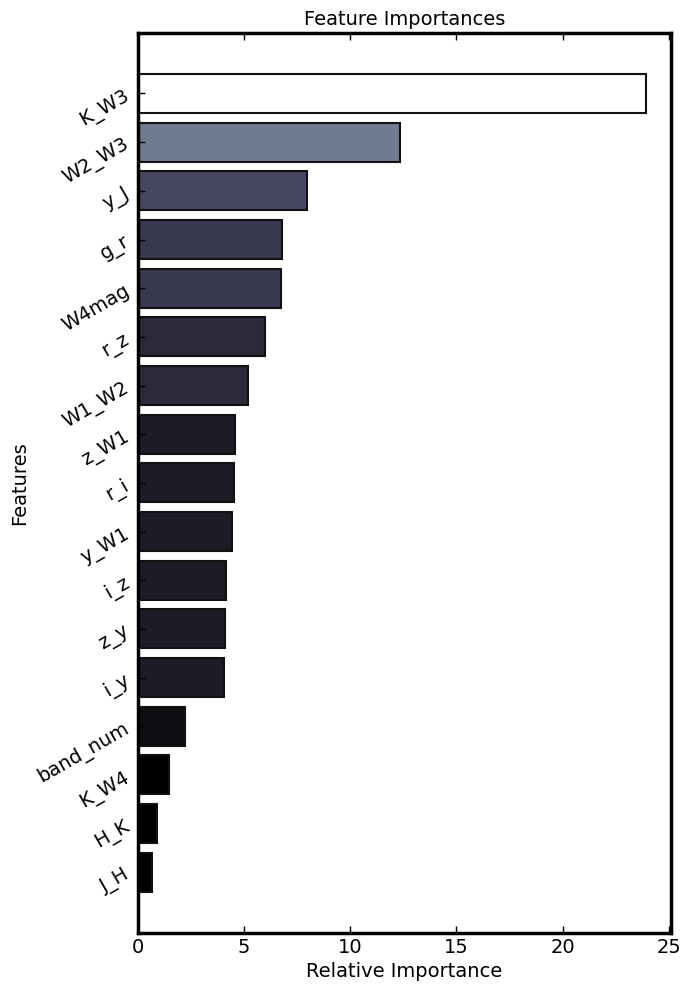

In [62]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = gf.get_feature_importances_df(final_radio_clf, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + 'feat_imp_classification_radio_detect_05.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

#### List optimised hyperparameters

In [63]:
hyperparams_models_df = gf.obtain_optimised_hyperpars(final_radio_clf, 'catboost', 'classification')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(hyperparams_models_df)

,catboost,rf,xgboost,et,gbc
learning_rate,0.0002,NaN,0.3000,NaN,0.1000
depth,1.0000,NaN,NaN,NaN,NaN
random_strength,0.1928,NaN,NaN,NaN,NaN
l2_leaf_reg,37.0000,NaN,NaN,NaN,NaN
n_estimators,NaN,100,100,100,100
max_depth,NaN,NaN,6.0000,NaN,3.0000
min_impurity_decrease,NaN,0.0000,NaN,0.0000,0.0000
max_features,NaN,auto,NaN,auto,None
bootstrap,NaN,True,NaN,False,NaN
criterion,NaN,gini,NaN,gini,NaN


---

In [64]:
print(f'Size of train set is {len(train_df):,}')
print(f'Size of test set is  {len(test_df):,}')

Size of train set is 15,820
Size of test set is  6,781


#### Calculate optimal threshold for classification

In [65]:
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df, probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
train_prediction_clf      = pyc.predict_model(final_radio_clf, data=train_df,      probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_radio_clf, data=test_df,       probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_radio_clf, data=train_test_df, probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7759292035,0.7564089682,0.5457280385,0.6396332863,0.5889610390,0.4362720837,0.4388701170


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8116940582,0.9330620904,0.6402160366,0.7119427119,0.6741769660,0.5422827509,0.5437947315


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7767290960,0.7636408992,0.5768854065,0.6444201313,0.6087855297,0.4532417940,0.4546014127


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8012034866,0.8833756933,0.6213535589,0.6918954036,0.6547298855,0.5157129417,0.5171829476


#### Naive threshold metrics.

In [66]:
cm_mat_val_naive        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])
cm_mat_train_naive      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test_naive       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_train_test_naive = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])

In [67]:
MCC_val_naive           = gf.MCC_from_CM(cm_mat_val_naive)
ACC_val_naive           = gf.ACC_from_CM(cm_mat_val_naive)
F1_val_naive            = gf.F1_from_CM(cm_mat_val_naive)
Recall_val_naive        = gf.Recall_from_CM(cm_mat_val_naive)

MCC_train_naive         = gf.MCC_from_CM(cm_mat_train_naive)
ACC_train_naive         = gf.ACC_from_CM(cm_mat_train_naive)
F1_train_naive          = gf.F1_from_CM(cm_mat_train_naive)
Recall_train_naive      = gf.Recall_from_CM(cm_mat_train_naive)

MCC_test_naive          = gf.MCC_from_CM(cm_mat_test_naive)
ACC_test_naive          = gf.ACC_from_CM(cm_mat_test_naive)
F1_test_naive           = gf.F1_from_CM(cm_mat_test_naive)
Recall_test_naive       = gf.Recall_from_CM(cm_mat_test_naive)

MCC_train_test_naive    = gf.MCC_from_CM(cm_mat_train_test_naive)
ACC_train_test_naive    = gf.ACC_from_CM(cm_mat_train_test_naive)
F1_train_test_naive     = gf.F1_from_CM(cm_mat_train_test_naive)
Recall_train_test_naive = gf.Recall_from_CM(cm_mat_train_test_naive)

naive_scores_array            = np.array([[F1_train_naive,      MCC_train_naive,      Recall_train_naive,      ACC_train_naive],\
                                          [F1_test_naive,       MCC_test_naive,       Recall_test_naive,       ACC_test_naive],\
                                          [F1_train_test_naive, MCC_train_test_naive, Recall_train_test_naive, ACC_train_test_naive],\
                                          [F1_val_naive,        MCC_val_naive,        Recall_val_naive,        ACC_val_naive]])

In [68]:
naive_scores_df = pd.DataFrame(data=naive_scores_array, columns=['F1', 'MCC', 'Recall', 'ACC'], index=['Train', 'Test', 'Train+Test', 'Validation'])

In [69]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(naive_scores_df)

,F1,MCC,Recall,ACC
Train,0.6742,0.5438,0.6402,0.8117
Test,0.6088,0.4546,0.5769,0.7767
Train+Test,0.6547,0.5172,0.6214,0.8012
Validation,0.5890,0.4389,0.5457,0.7759


In [70]:
validation_prediction_clf.loc[:, ['Score_0', 'Score_1']].describe()

,Score_0,Score_1
count,5650.000000,5650.000000
mean,0.503043,0.496957
std,0.002655,0.002655
min,0.498524,0.495214
25%,0.499937,0.495214
50%,0.504786,0.495214
75%,0.504786,0.500063
max,0.504786,0.501476


#### Calculate optimal threshold for prediction

Calculate ROC AUC values and plots.

In [71]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_train_test = roc_auc_score(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

In [72]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for train+test = {roc_auc_train_test:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.93306
Area under the curve (ROC) for test       = 0.76364
Area under the curve (ROC) for train+test = 0.88338
Area under the curve (ROC) for validation = 0.75641


In [73]:
fpr_train,      tpr_train,      thresh_train      = roc_curve(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,       tpr_test,       thresh_test       = roc_curve(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
fpr_train_test, tpr_train_test, thresh_train_test = roc_curve(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
fpr_val,        tpr_val,        thresh_val        = roc_curve(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

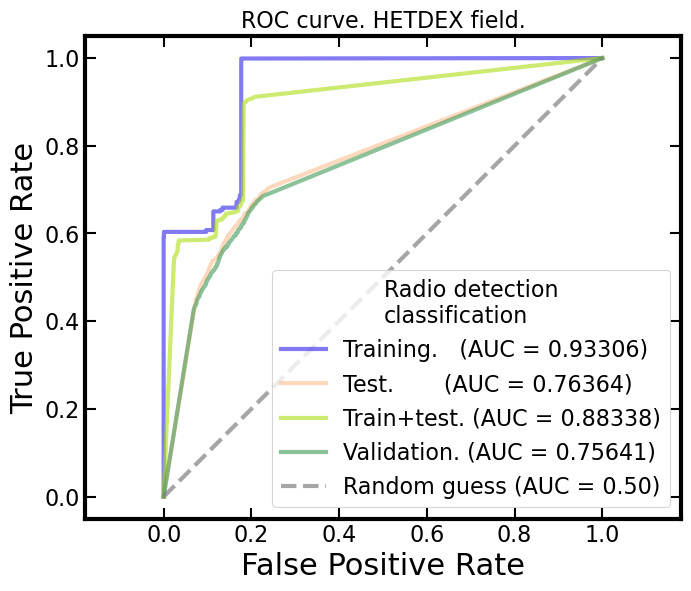

In [74]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = RocCurveDisplay(fpr=fpr_train,      tpr=tpr_train,      roc_auc=roc_auc_train)
viz_test        = RocCurveDisplay(fpr=fpr_test,       tpr=tpr_test,       roc_auc=roc_auc_test)
viz_train_test  = RocCurveDisplay(fpr=fpr_train_test, tpr=tpr_train_test, roc_auc=roc_auc_train_test)
viz_val         = RocCurveDisplay(fpr=fpr_val,        tpr=tpr_val,        roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training.   (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,        lw=3, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test.       (AUC = {roc_auc_test:0.5f})")
viz_train_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+test. (AUC = {roc_auc_train_test:0.5f})")
viz_val.plot(ax=ax1,         lw=3, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Validation. (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=22)
ax1.set_ylabel('True Positive Rate', fontsize=22)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=16, title='Radio detection\nclassification', title_fontsize=16)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'AUC_ROC_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

##### Obtain optimal thresholds from each sub-set

In [75]:
opt_thres_train      = thresh_train[np.argmax(tpr_train - fpr_train)]
opt_thres_test       = thresh_test[np.argmax(tpr_test - fpr_test)]
opt_thres_train_test = thresh_train_test[np.argmax(tpr_train_test - fpr_train_test)]
opt_thres_validation = thresh_val[np.argmax(tpr_val - fpr_val)]

In [76]:
print(f'Optimal threshold from area under the curve (ROC) for training   = {opt_thres_train:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for test       = {opt_thres_test:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for train+test = {opt_thres_train_test:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for validation = {opt_thres_validation:.8e}')

Optimal threshold from area under the curve (ROC) for training   = 4.96036517e-01
Optimal threshold from area under the curve (ROC) for test       = 4.95372870e-01
Optimal threshold from area under the curve (ROC) for train+test = 4.95866031e-01
Optimal threshold from area under the curve (ROC) for validation = 4.95452370e-01


##### Precision-Recall curve

In [77]:
prec_train,      recall_train,      thresh_train      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_test,       recall_test,       thresh_test       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Score_1'],       pos_label=1)
prec_train_test, recall_train_test, thresh_train_test = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_validation, recall_validation, thresh_validation = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Score_1'], pos_label=1)

AUC for PR curve

In [78]:
auc_pr_train      = auc(recall_train,      prec_train)
auc_pr_test       = auc(recall_test,       prec_test)
auc_pr_train_test = auc(recall_train_test, prec_train_test)
auc_pr_validation = auc(recall_validation, prec_validation)

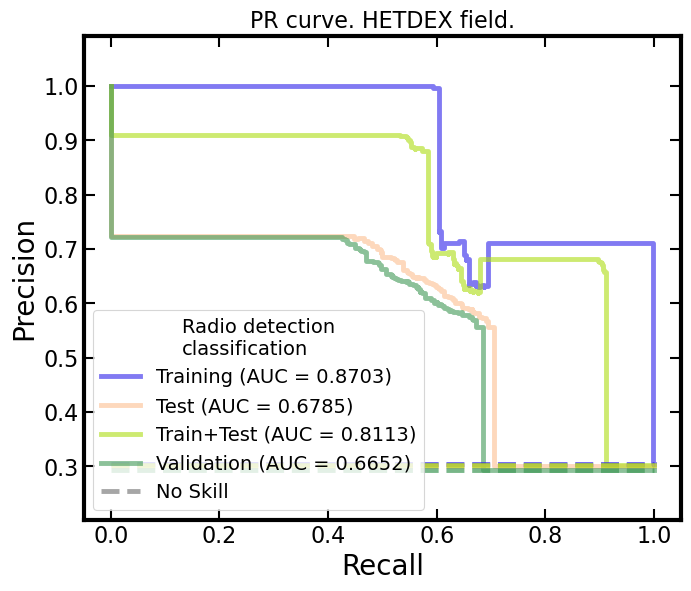

In [79]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train,      recall=recall_train)
viz_test        = PrecisionRecallDisplay(precision=prec_test,       recall=recall_test)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test, recall=recall_train_test)
viz_val         = PrecisionRecallDisplay(precision=prec_validation, recall=recall_validation)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training (AUC = {auc_pr_train:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test (AUC = {auc_pr_test:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test (AUC = {auc_pr_train_test:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Validation (AUC = {auc_pr_validation:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.7, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=14, title='Radio detection\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_curve_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [80]:
fscore_train      = (2 * prec_train      * recall_train)      / (prec_train      + recall_train)
fscore_test       = (2 * prec_test       * recall_test)       / (prec_test       + recall_test)
fscore_train_test = (2 * prec_train_test * recall_train_test) / (prec_train_test + recall_train_test)
fscore_validation = (2 * prec_validation * recall_validation) / (prec_validation + recall_validation)

In [81]:
opt_t_PR_train      = thresh_train[np.argmax(fscore_train)]
opt_t_PR_test       = thresh_test[np.argmax(fscore_test)]
opt_t_PR_train_test = thresh_train_test[np.argmax(fscore_train_test)]
opt_t_PR_validation = thresh_validation[np.argmax(fscore_validation)]

In [82]:
print(f'Optimal threshold from Precision-Recall curve for training   = {opt_t_PR_train:.8e}')
print(f'Optimal threshold from Precision-Recall curve for test       = {opt_t_PR_test:.8e}')
print(f'Optimal threshold from Precision-Recall curve for train+test = {opt_t_PR_train_test:.8e}')
print(f'Optimal threshold from Precision-Recall curve for validation = {opt_t_PR_validation:.8e}')

Optimal threshold from Precision-Recall curve for training   = 4.96036517e-01
Optimal threshold from Precision-Recall curve for test       = 4.95539437e-01
Optimal threshold from Precision-Recall curve for train+test = 4.95866031e-01
Optimal threshold from Precision-Recall curve for validation = 4.95452370e-01


#### Calibration curve

In [83]:
fract_positiv_train_test, mean_pred_val_train_test =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=20, normalize=True)  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val, mean_pred_val_val =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=20, normalize=True)  # calibration_curve(y_test, prob_pos, n_bins=10)

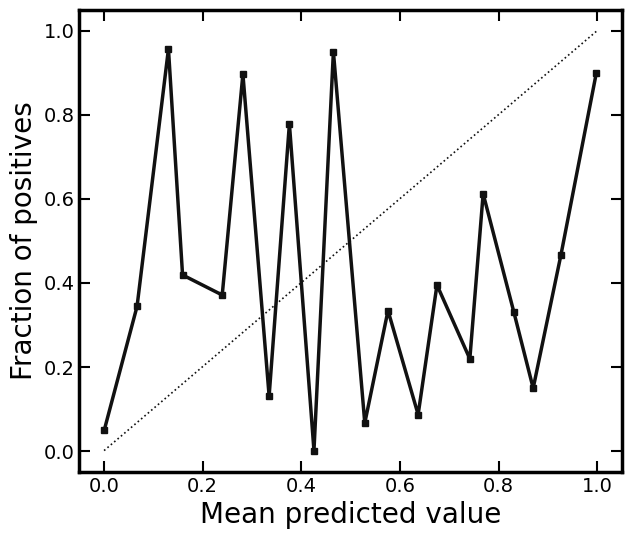

In [122]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_train_test, fract_positiv_train_test, ls='-', marker='s', c='k', lw=2.5)
ax1.plot([0, 1], [0, 1], ls=':', c='k', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.show()

---

In [85]:
radio_pred_threshold = float(opt_t_PR_train_test) # 4.95866031e-01

In [86]:
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df, probability_threshold=radio_pred_threshold, raw_score=True, round=10)
train_prediction_clf      = pyc.predict_model(final_radio_clf, data=train_df,      probability_threshold=radio_pred_threshold, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_radio_clf, data=test_df,       probability_threshold=radio_pred_threshold, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_radio_clf, data=train_test_df, probability_threshold=radio_pred_threshold, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7601769912,0.7564089682,0.6257521059,0.5865764241,0.6055312955,0.4335073860,0.4339749322


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8766118837,0.9330620904,0.9989613627,0.7118117229,0.8312878133,0.7382788830,0.7646547877


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7596224746,0.7636408992,0.6571988247,0.5906690141,0.6221604080,0.4466398116,0.4480075881


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8415114375,0.8833756933,0.8971703617,0.6813247674,0.7744900529,0.6557994310,0.6705671221


Create confusion matrices.

In [87]:
cm_mat_val        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])
cm_mat_train      = gf.conf_mat_func(train_prediction_clf[target_feat], train_prediction_clf['Label'])
cm_mat_test       = gf.conf_mat_func(test_prediction_clf[target_feat], test_prediction_clf['Label'])
cm_mat_train_test = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])

In [88]:
MCC_radio_train         = gf.MCC_from_CM(cm_mat_train)
ACC_radio_train         = gf.ACC_from_CM(cm_mat_train)
F1_radio_train          = gf.F1_from_CM(cm_mat_train)
Recall_radio_train      = gf.Recall_from_CM(cm_mat_train)

MCC_radio_test          = gf.MCC_from_CM(cm_mat_test)
ACC_radio_test          = gf.ACC_from_CM(cm_mat_test)
F1_radio_test           = gf.F1_from_CM(cm_mat_test)
Recall_radio_test       = gf.Recall_from_CM(cm_mat_test)

MCC_radio_train_test    = gf.MCC_from_CM(cm_mat_train_test)
ACC_radio_train_test    = gf.ACC_from_CM(cm_mat_train_test)
F1_radio_train_test     = gf.F1_from_CM(cm_mat_train_test)
Recall_radio_train_test = gf.Recall_from_CM(cm_mat_train_test)

MCC_radio_val           = gf.MCC_from_CM(cm_mat_val)
ACC_radio_val           = gf.ACC_from_CM(cm_mat_val)
F1_radio_val            = gf.F1_from_CM(cm_mat_val)
Recall_radio_val        = gf.Recall_from_CM(cm_mat_val)

radio_scores_array      = np.array([[F1_radio_train,      MCC_radio_train,      Recall_radio_train,      ACC_radio_train],\
                                    [F1_radio_test,       MCC_radio_test,       Recall_radio_test,       ACC_radio_test],\
                                    [F1_radio_train_test, MCC_radio_train_test, Recall_radio_train_test, ACC_radio_train_test],\
                                    [F1_radio_val,        MCC_radio_val,        Recall_radio_val,        ACC_radio_val]])

In [89]:
radio_scores_array_df = pd.DataFrame(data=radio_scores_array, columns=['F1', 'MCC', 'Recall', 'ACC'], index=['Train', 'Test', 'Train+Test', 'Validation'])

In [90]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(radio_scores_array_df)

,F1,MCC,Recall,ACC
Train,0.8313,0.7647,0.9990,0.8766
Test,0.6222,0.4480,0.6572,0.7596
Train+Test,0.7745,0.6706,0.8972,0.8415
Validation,0.6055,0.4340,0.6258,0.7602


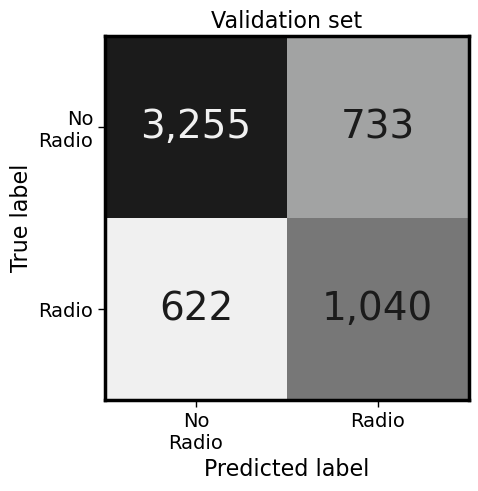

In [91]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_validation_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

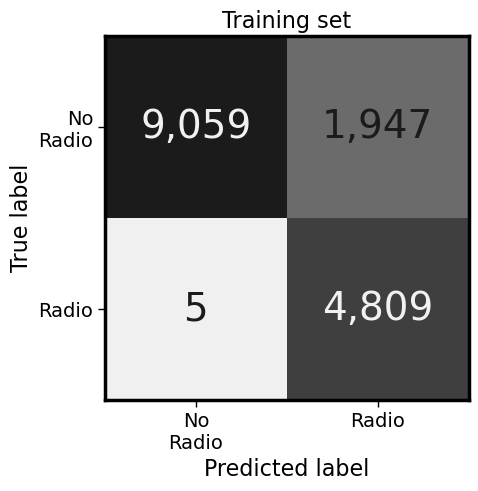

In [92]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

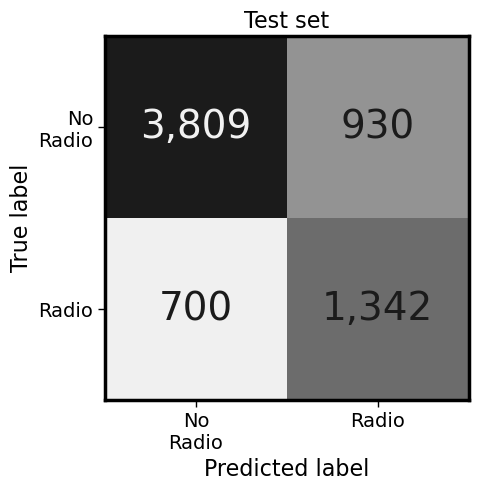

In [93]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_test_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

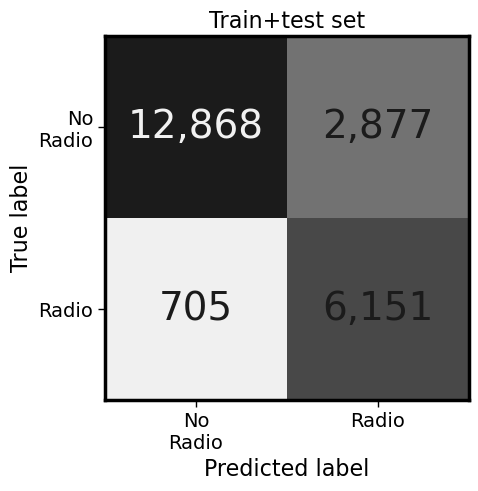

In [94]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_train_test, title='Train+test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_test_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

### Calibrate model and save it separately

In [95]:
print('Running data pre-processing for calibration (train+test):\n')
extended_train_test_df = gf.preprocess_data(final_radio_clf, train_test_df, base_models_names)
initial_cols           = extended_train_test_df.columns.drop(base_models_names)

Running data pre-processing for calibration (train+test):



In [96]:
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    calibrated_final_radio_clf = CalibratedClassifierCV(base_estimator=final_radio_clf.named_steps['trained_model'], cv='prefit', method='isotonic')
    calibrated_final_radio_clf.fit(train_test_df.loc[:, gf.get_final_column_names(final_radio_clf, train_test_df)], train_test_df.loc[:, target_feat])
else:
    calibrated_final_radio_clf = CalibratedClassifierCV(base_estimator=final_radio_clf, cv='prefit', method='isotonic')
    calibrated_final_radio_clf.fit(train_test_df.loc[:, pyc.get_config('X').columns], train_test_df.loc[:, target_feat])

In [97]:
pred_cal_prob_train      = calibrated_final_radio_clf.predict_proba(train_df.loc[:, initial_cols])[:, 1]
pred_cal_prob_test       = calibrated_final_radio_clf.predict_proba(test_df.loc[:, initial_cols])[:, 1]
pred_cal_prob_train_test = calibrated_final_radio_clf.predict_proba(train_test_df.loc[:, initial_cols])[:, 1]
pred_cal_prob_validation = calibrated_final_radio_clf.predict_proba(validation_df.loc[:, initial_cols])[:, 1]

##### Obtain optimal thresholds from train+test in calibrated model

##### Precision-Recall curve

In [98]:
prec_train_cal,      recall_train_cal,      thresh_train_cal      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               pred_cal_prob_train,      pos_label=1)
prec_test_cal,       recall_test_cal,       thresh_test_cal       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               pred_cal_prob_test,       pos_label=1)
prec_train_test_cal, recall_train_test_cal, thresh_train_test_cal = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               pred_cal_prob_train_test, pos_label=1)
prec_validation_cal, recall_validation_cal, thresh_validation_cal = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               pred_cal_prob_validation, pos_label=1)

AUC for PR curve

In [99]:
auc_pr_train_cal      = auc(recall_train_cal,      prec_train_cal)
auc_pr_test_cal       = auc(recall_test_cal,       prec_test_cal)
auc_pr_train_test_cal = auc(recall_train_test_cal, prec_train_test_cal)
auc_pr_validation_cal = auc(recall_validation_cal, prec_validation_cal)

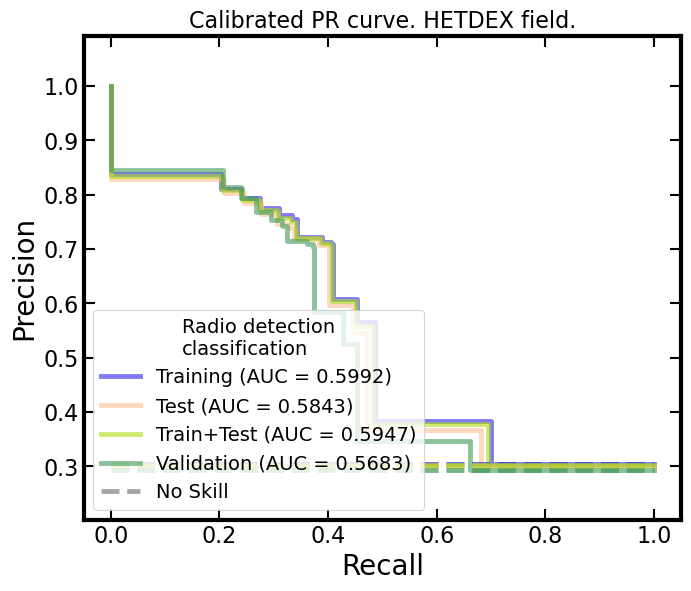

In [100]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train_cal,      recall=recall_train_cal)
viz_test        = PrecisionRecallDisplay(precision=prec_test_cal,       recall=recall_test_cal)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test_cal, recall=recall_train_test_cal)
viz_val         = PrecisionRecallDisplay(precision=prec_validation_cal, recall=recall_validation_cal)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training (AUC = {auc_pr_train_cal:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test (AUC = {auc_pr_test_cal:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test (AUC = {auc_pr_train_test_cal:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Validation (AUC = {auc_pr_validation_cal:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.7, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=14, title='Radio detection\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('Calibrated PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_cal_curve_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [101]:
fscore_train_cal      = (2 * prec_train_cal      * recall_train_cal)      / (prec_train_cal      + recall_train_cal)
fscore_test_cal       = (2 * prec_test_cal       * recall_test_cal)       / (prec_test_cal       + recall_test_cal)
fscore_train_test_cal = (2 * prec_train_test_cal * recall_train_test_cal) / (prec_train_test_cal + recall_train_test_cal)
fscore_validation_cal = (2 * prec_validation_cal * recall_validation_cal) / (prec_validation_cal + recall_validation_cal)

In [102]:
opt_t_PR_train_cal      = thresh_train_cal[np.argmax(fscore_train_cal)]
opt_t_PR_test_cal       = thresh_test_cal[np.argmax(fscore_test_cal)]
opt_t_PR_train_test_cal = thresh_train_test_cal[np.argmax(fscore_train_test_cal)]
opt_t_PR_validation_cal = thresh_validation_cal[np.argmax(fscore_validation_cal)]

In [103]:
print('Otimal thresholds from calibrated Precision-Recal curves:')
print(f'Optimal threshold from Precision-Recall curve for training   = {opt_t_PR_train_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test       = {opt_t_PR_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test = {opt_t_PR_train_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation = {opt_t_PR_validation_cal:.5f}')

Otimal thresholds from calibrated Precision-Recal curves:
Optimal threshold from Precision-Recall curve for training   = 0.26015
Optimal threshold from Precision-Recall curve for test       = 0.47170
Optimal threshold from Precision-Recall curve for train+test = 0.26015
Optimal threshold from Precision-Recall curve for validation = 0.26124


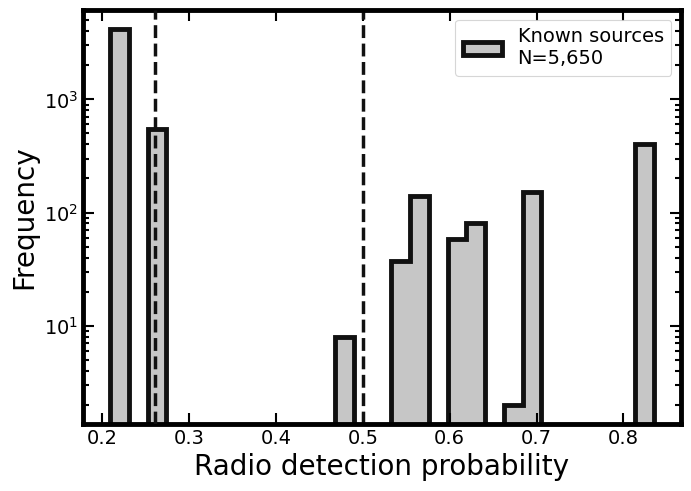

In [104]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(pred_cal_prob_validation)
max_score  = np.nanmax(pred_cal_prob_validation)
score_bins = np.linspace(min_score, max_score, 30)

sample_size = len(pred_cal_prob_validation)

ax1.hist(pred_cal_prob_validation, bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'Known sources\nN={sample_size:,}')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
ax1.axvline(x=opt_t_PR_train_test_cal, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'hist_predicted_radio_cal_scores_pred_AGN_known.pdf', bbox_inches='tight')
plt.show()

#### Calibration curve

In [123]:
fract_positiv_train_test_cal, mean_pred_val_train_test_cal =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          pred_cal_prob_train_test,\
                                          n_bins=20, normalize=True)  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val_cal, mean_pred_val_val_cal =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          pred_cal_prob_validation,\
                                          n_bins=20, normalize=True)  # calibration_curve(y_test, prob_pos, n_bins=10)

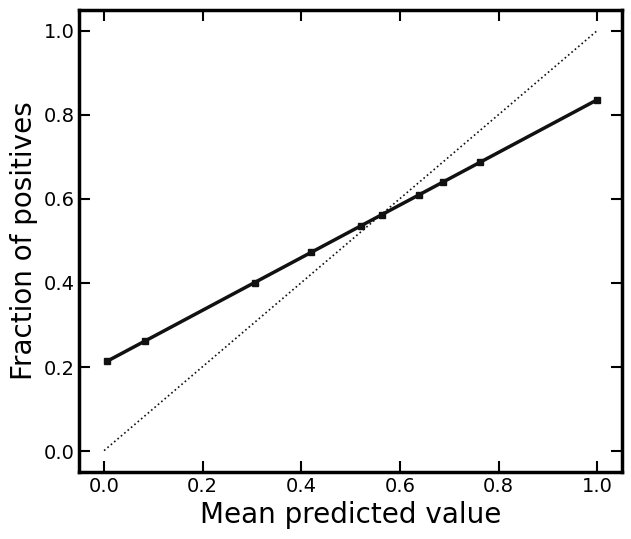

In [124]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_train_test_cal, fract_positiv_train_test_cal, ls='-', marker='s', c='k', lw=2.5)
ax1.plot([0, 1], [0, 1], ls=':', c='k', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.show()

In [108]:
if save_model_flag:
    dump(calibrated_final_radio_clf, gv.models_path + gv.cal_radio_model)

In [106]:
# if load_model_flag:
#     clf_test = load(gv.models_path + gv.cal_radio_model)

In [107]:
# clf_test.predict_proba(validation_df.loc[:, get_final_column_names(final_radio_clf, validation_df)])